## Binary Classification on MNIST: Training, Evaluation, and Performance Metrics

In [80]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [65]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']

print(X.shape, y.shape)

(70000, 784) (70000,)


**Observation:**

The MNIST dataset contains 70,000 images, each of size 28×28 pixels, flattened into a 784-dimensional feature vector.

__`X.shape = (70000, 784)`__ confirms there are 70,000 instances and 784 features per instance.  each image is 28×28 pixels

__`y.shape = (70000,)`__ shows there are 70,000 corresponding labels, one for each image.


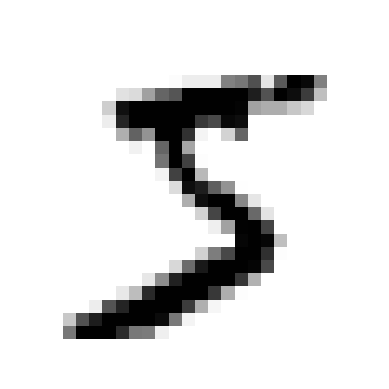

In [66]:
some_digit = X[0]          # first MNIST digit (784 pixels)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

**Observation:**

- The first image from the MNIST dataset is visualized.
- The image is 28×28 pixels, reconstructed from the 784-dimensional feature vector.
- We can see that the number of the image looks like 5 lets see what's its corresponding value

In [67]:
y[0]

'5'

**Observation**

- It was actually 5, so we need to make the similar kind of prediction but on the unseen data


In [68]:
print(y.dtype)
y = y.astype(np.int8)
print(y.dtype)

object
int8


**Observation**

- At first the y column was object type, which is a string type. After conversion to int 8, it is now an integer type.

In [69]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Observation**

- The training and test sets contain 60,000 and 10,000 digits, respectively.
- The split is made before inspecting the data closely

__`Detecting Digit ‘5’ in MNIST`__

In [70]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

**Observation**

- y_train_5 is a boolean array with 60000 entries.
- So, we want the prediction for only digit 5

In [71]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [72]:

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

**Observation**

- SGDClassifier is a Stochastic Gradient Descent classifier, a linear model that can efficiently handle large datasets like MNIST.
- We are training a binary classifier to detect the digit ‘5’:
- y_train_5 = True for digit 5
- y_train_5 = False for all other digits
- __`fit() method`__

Trains the model by finding the optimal weights that separate the positive class (5) from the negative class (not-5).

In [73]:
sgd_clf.predict([some_digit])

array([ True])

**Observatoin**

- The classifier is pretty good at predicting 5s as it returned __`True`__ for __`some_digit`__ which was 5

In [74]:

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) #

0.95035
0.96035
0.9604


Cross-Validation

- We want to evaluate how well the classifier performs on unseen data.
- StratifiedKFold splits the training set into 3 folds, keeping the class proportions the same in each fold (important because 5s are rare).
- clone() Creates a fresh copy of the SGDClassifier for each fold, Ensures no information leaks between folds (no contamination).

Observation:

- It computes accuracy for each fold of the training data.
- The SGD classifier can correctly identify ~96% of digits as 5 or not-5 on unseen folds of the training data.
- High accuracy, but remember: for imbalanced data (few 5s), precision and recall are more informative than accuracy.


In [75]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Why it can be misleading

- The problem is binary classification on an imbalanced dataset:
- Only ~10% of images are digit 5 → the positive class is rare.
- 90% are not 5 → the negative class is dominant.
- A classifier could just predict “not 5” for everything:
- It would be right 90% of the time → accuracy = 90%
- But it fails completely at detecting 5s, which is the actual goal.
- Therefore, the high accuracy does not reflect the classifier’s real ability to detect digit 5.

### Confusion Matrix

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)

<img src="confusion_matrix.jpg" alt="Drawing" style="width: 600px;"/>

<img src="confusion_matrix.png" alt="Drawing" style="width: 500px;"/>

In [ ]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

If We can reach the perfection then the confusion_matrix will look like this
<img src="confusion_matrix_perfect.png" alt="Drawing" style="width: 500px;"/>

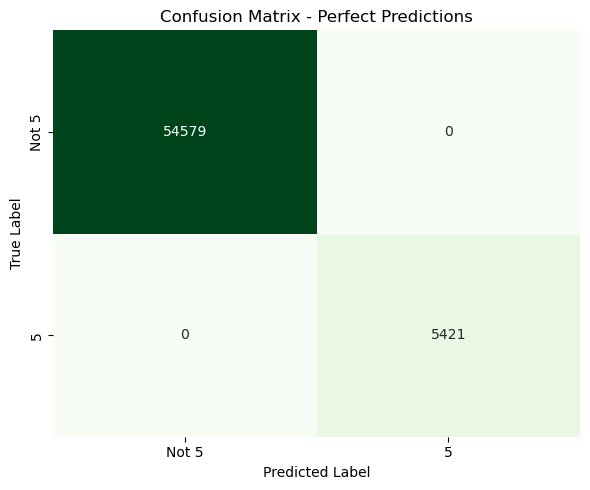

In [84]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


**Observation / Explanation**

Precision (~83.7%)
- When the classifier predicts a digit as 5, it is correct 83.7% of the time.
- This means the classifier is reasonably good at avoiding false positives (misclassifying non-5 digits as 5).

Recall (~65.1%)

- The classifier correctly detects 65.1% of all actual 5 digits.
- This means it misses about 34.9% of actual 5s (false negatives).

Insight

- Although the classifier is precise, it fails to detect some 5s, showing that accuracy alone is misleading for imbalanced datasets.
- There is a tradeoff between precision and recall: improving one often reduces the other.

## F1 Score
The **F1-score** is the harmonic mean of **precision** and **recall**:

$$
F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

- It balances precision and recall into a **single metric**.
- Useful when you want a **single number to evaluate performance**, especially on **imbalanced datasets**.



In [86]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

The F1-score of the SGD classifier for detecting digit 5 is approximately **0.733**.

- This value represents the **harmonic mean of precision and recall**.
- It balances **precision (~83.7%)** and **recall (~65.1%)** into a single metric.
- Since the dataset is imbalanced (few 5s compared to non-5s), the F1-score provides a **more realistic measure of performance** than accuracy alone.


In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")


In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
print(precision_score(y_train_5, y_train_pred_90))  # ~0.90
print(recall_score(y_train_5, y_train_pred_90))    # ~0.44


0.9000345901072293
0.4799852425751706


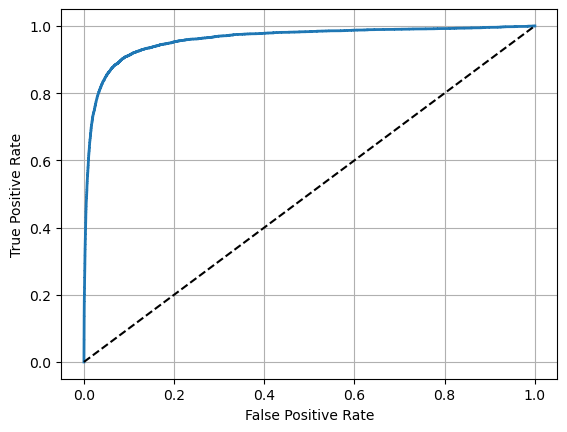

In [ ]:


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')  # random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()


In [ ]:

roc_auc_score(y_train_5, y_scores)  # e.g., 0.961 → very good


0.9604938554008616

In [ ]:


forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)
y_scores_forest = y_probas_forest[:, 1]  # probability of positive class


In [ ]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

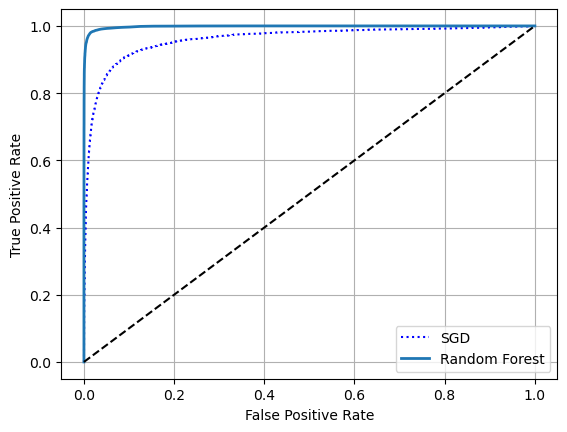

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [ ]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145